In [1]:
import pandas as pd
import numpy as np
import iisignature 
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Load the dataset
stock_data = pd.read_csv("stock_details_5_years.csv")


In [3]:
#Parsing the date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], utc=True).dt.tz_localize(None).dt.date

In [4]:
#Delete useless company
target_date = pd.Timestamp('2022-02-01')
valid_companies = stock_data.loc[stock_data['Date'] == target_date, 'Company'].unique()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [5]:
#Retain company data that exists on the target date
stock_data = stock_data[stock_data['Company'].isin(valid_companies)]


In [6]:
#Data for simulate
start_date = pd.Timestamp('2022-02-01')
end_date = pd.Timestamp('2022-09-19')


pred_date = pd.Timestamp('2022-10-20')

#Get data for a specific time period
true_stock_data = stock_data[(stock_data['Date'] >= start_date) & (stock_data['Date'] <= end_date)]

pred_stock_data = stock_data[(stock_data['Date'] == pred_date)][['Company', 'Close']].rename(columns={'Close': 'true_y'})


In [7]:
# Def fuc to calculate signature 
def calculate_signature(data):
    company = data['Company'].iloc[0]
    date = data['Date'].iloc[0]
    company_data = true_stock_data[(true_stock_data['Company'] == company) & (true_stock_data['Date'] <= date)]
    if len(company_data) > 0:
        close_values = company_data['sim_Close'].values.reshape(-1, 1)  #Convert to a 2D array
        open_values = company_data['sim_Open'].values.reshape(-1, 1)   #Convert to a 2D array
        #Compute first-order and second-order signatures
        signature_close_1 = iisignature.sig(close_values, 1)
        signature_volume_1 = iisignature.sig(open_values, 1)
        signature_close_2 = iisignature.sig(close_values, 2)
        signature_volume_2 = iisignature.sig(open_values, 2)
        #Concatenate signature data
        signature = np.concatenate((signature_close_1, signature_volume_1, signature_close_2, signature_volume_2), axis=None)
        return pd.Series({'Signature': signature})
    else:
        return pd.Series({'Signature': None})

#Calculate the signature
signatures = true_stock_data.groupby(['Company', 'Date']).apply(calculate_signature)
true_stock_data = true_stock_data.merge(signatures, left_on=['Company', 'Date'], right_index=True)


In [8]:
#Change 1 col into 6
true_stock_data[['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']] = pd.DataFrame(true_stock_data['Signature'].tolist(), index=true_stock_data.index)

#Delete old col
true_stock_data = true_stock_data.drop(columns=['Signature'])



In [9]:
true_stock_data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,Signature1,Signature2,Signature3,Signature4,Signature5,Signature6
378347,2022-02-01,172.044269,172.864895,170.363476,172.637497,86213900,0.0,0.0,AAPL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378348,2022-02-01,304.825540,305.041583,299.640532,303.205231,40950400,0.0,0.0,MSFT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378349,2022-02-01,137.594498,137.792999,134.368500,137.643997,68644000,0.0,0.0,GOOGL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378350,2022-02-01,150.000000,151.707993,147.627502,151.193497,59220000,0.0,0.0,AMZN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
378351,2022-02-01,250.716281,251.125756,238.591936,246.062302,51892500,0.0,0.0,NVDA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455656,2022-09-19,27.833128,28.334974,27.746270,28.325323,3811800,0.0,0.0,PPL,0.512913,-0.045233,0.512913,0.131540,-0.045233,0.001023
455657,2022-09-19,32.519634,33.518499,32.519634,33.395996,3564400,0.0,0.0,FITB,-9.242599,-8.828853,-9.242599,42.712823,-8.828853,38.974320
455658,2022-09-19,96.715681,98.326658,96.639420,98.088348,1285500,0.0,0.0,IFF,-28.073158,-27.667711,-28.073158,394.051107,-27.667711,382.751115
455659,2022-09-19,27.095068,28.419937,27.045259,28.190823,3504200,0.0,0.0,CCJ,8.028906,7.490990,8.028906,32.231665,7.490990,28.057466


In [10]:
#Lasso regression for each company
results = []

for company in valid_companies:
    company_data = true_stock_data[true_stock_data['Company'] == company]
    
    train_x = company_data[(company_data['Date'] >= pd.Timestamp('2022-02-01').date()) & (company_data['Date'] <= pd.Timestamp('2022-08-19').date())][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    train_y = company_data[(company_data['Date'] >= pd.Timestamp('2022-03-03').date()) & (company_data['Date'] <= pd.Timestamp('2022-09-19').date())]['Close']
    
    #Ensure train_x and train_y are aligned
    train_x = train_x.iloc[1:].reset_index(drop=True)
    train_y = train_y.reset_index(drop=True)
    
    #Perform LassoCV
    lasso = LassoCV(cv=5, random_state=2024)
    lasso.fit(train_x, train_y)
    
    #Predict the value
    test_x = company_data[company_data['Date'] == pd.Timestamp('2022-09-19').date()][['Signature1', 'Signature2', 'Signature3', 'Signature4', 'Signature5', 'Signature6']]
    predict_y = lasso.predict(test_x)[0]
    
    results.append({'Company': company, 'predicted_y': predict_y})

    
#Create results DataFrame
results_df = pd.DataFrame(results)

#Merge true values with predictions
true_result = pred_stock_data.merge(results_df, on='Company')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8274598660227639, tolerance: 0.7928952099174121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.983720321560213, tolerance: 0.7928952099174121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3365118172896473, tolerance: 0.7928952099174121
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.329e-01, tolerance: 4.794e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.156151038783719, tolerance: 13.089780584015609
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.18618572759442, tolerance: 13.089780584015609
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-package

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.522e+01, tolerance: 2.880e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0741583391727545, tolerance: 0.06481359624973636
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07423069157403006, tolerance: 0.06481359624973636
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-pac

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.428235322917317, tolerance: 2.35220186098423
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3319812352092413, tolerance: 2.35220186098423
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.615166565290565, tolerance: 2.35220186098423
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: Conv

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8713567456079545, tolerance: 0.8357149431404302
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9535473396053931, tolerance: 0.8357149431404302
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0145172318516416, tolerance: 0.8357149431404302
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2065167839548394, tolerance: 0.13105402684952142
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0406461202963726, tolerance: 0.03273019267516647
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04154712275757788, tolerance: 0.03273019267516647
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124.78044804372803, tolerance: 1.1697226823643214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165.8323258826349, tolerance: 1.1697226823643214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169.47482915257933, tolerance: 1.1697226823643214
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:63

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e-02, tolerance: 1.129e-03
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.601374507496075, tolerance: 7.17835943945741
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.669732506525179, tolerance: 7.17835943945741
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sk

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08966630734198588, tolerance: 0.08212350128946057
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1106342624982517, tolerance: 0.08212350128946057
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11535048078781074, tolerance: 0.08212350128946057
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.312e+01, tolerance: 1.737e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e-04, tolerance: 3.168e-04
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.096299611311224, tolerance: 0.07289060846589432
  model = cd_fast.enet_coordinate_descen

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5178016968034171, tolerance: 0.4606406067303544
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5599518942167379, tolerance: 0.4606406067303544
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5898099734276911, tolerance: 0.4606406067303544
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7666512635723848, tolerance: 0.5778329885848799
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.094e-01, tolerance: 2.680e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8509798556913211, tolerance: 0.36575004101715053
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.979e+00, tolerance: 4.420e-01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7652311441484017, tolerance: 0.4540459232107688
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7812794063906949, tolerance: 0.4540459232107688
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8481223325647989, tolerance: 0.49410839469798806
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.929469579232318, tolerance: 1.2588801154550138
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.895115728540077, tolerance: 1.2588801154550138
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.647e+01, tolerance: 6.226e-02
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5772565930610654, tolerance: 0.46448698390374843
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.21302025406112, tolerance: 0.46448698390374843
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.38789283123333, tolerance: 20.092931560258968
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.7356528439268, tolerance: 20.092931560258968
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29.37413802361698, tolerance: 20.092931560258968
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2064127114240364, tolerance: 0.4205962308017237
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5664015184602249, tolerance: 0.4094878617108355
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4615059435727744, tolerance: 0.4094878617108355
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6565501783461514, tolerance: 1.6919030386301834
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.303264745101842, tolerance: 1.6919030386301834
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.827859733642072, tolerance: 1.6919030386301834
  model = cd_fast.enet_coordinate_descent_gram(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e-01, tolerance: 9.630e-02
  model = cd_fast.enet_coordinate_descent(


In [11]:
#Calcilate difference
true_result["difference"] = (true_result["true_y"] - true_result["predicted_y"]).abs()
true_result["difference_percentage"] = (true_result["difference"] / true_result["true_y"]) * 100

#Sort by difference
true_result_sorted = true_result.sort_values(by="difference")


#Print first and last 10 lines
print("10 lines with lowest difference:")
print(true_result_sorted.head(10))

# 打印后十行
print("\n 10 lines with highest difference:")
print(true_result_sorted.tail(10))

10 lines with lowest difference:
    Company     true_y  predicted_y  difference  difference_percentage
254    ABEV   2.685024     2.694306    0.009282               0.345680
167     SAN   2.424991     2.457075    0.032084               1.323040
239     KDP  36.374649    36.413486    0.038837               0.106769
437    PINS  22.969999    22.929490    0.040509               0.176357
285     WDS  19.650753    19.700889    0.050136               0.255133
360     SYM  12.300000    12.372665    0.072665               0.590773
202       E  21.687094    21.598653    0.088441               0.407804
224     AFL  57.460747    57.371039    0.089708               0.156120
311     BBD   3.602664     3.504615    0.098050               2.721589
474    CTRA  27.678749    27.786746    0.107997               0.390179

 10 lines with highest difference:
    Company       true_y  predicted_y  difference  difference_percentage
131    MELI   820.469971   932.014771  111.544800              13.595233
386 

In [12]:
#Calculate overall R² score
overall_r2_score = r2_score(true_result['true_y'], true_result['predicted_y'])
print(f"R² score: {overall_r2_score}")

R² score: 0.981847663044255


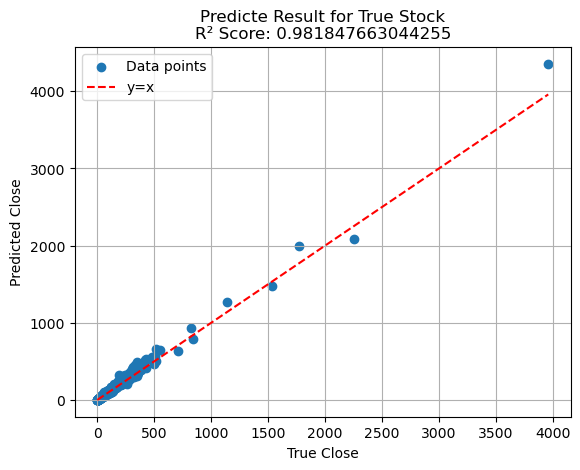

In [13]:
#Plot
plt.scatter(true_result['true_y'], true_result['predicted_y'], label='Data points')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title(f'Predicte Result for True Stock\nR² Score: {overall_r2_score}')
plt.plot([true_result['true_y'].min(), true_result['true_y'].max()], [true_result['true_y'].min(), true_result['true_y'].max()], 'r--', label='y=x')
plt.legend()
plt.grid(True)
plt.show()

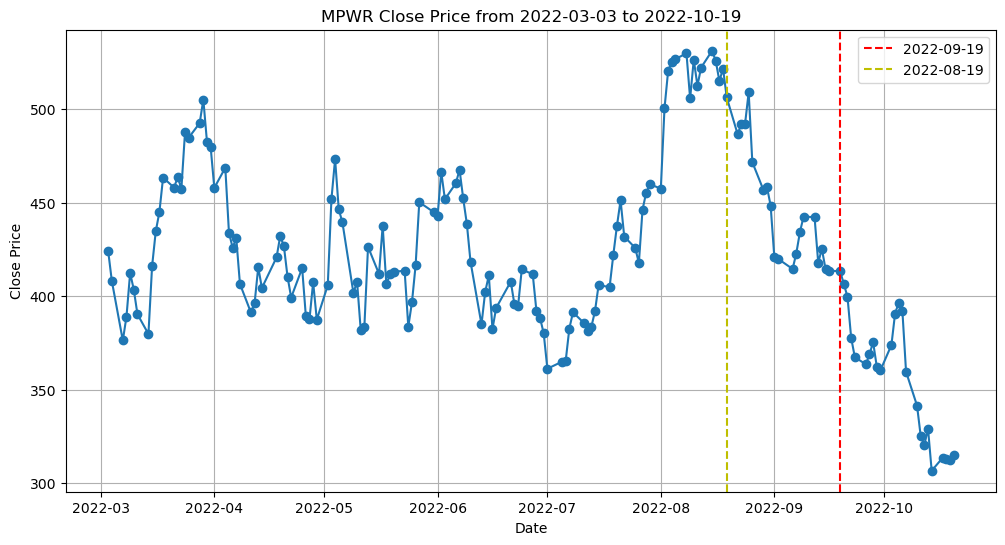

In [14]:
companyplot = 'MPWR'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-03-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2022-10-20').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-03-03 to 2022-10-19')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-09-19'), color='r', linestyle='--', label='2022-09-19')
plt.axvline(pd.to_datetime('2022-08-19'), color='y', linestyle='--', label='2022-08-19')
plt.legend()

plt.show()

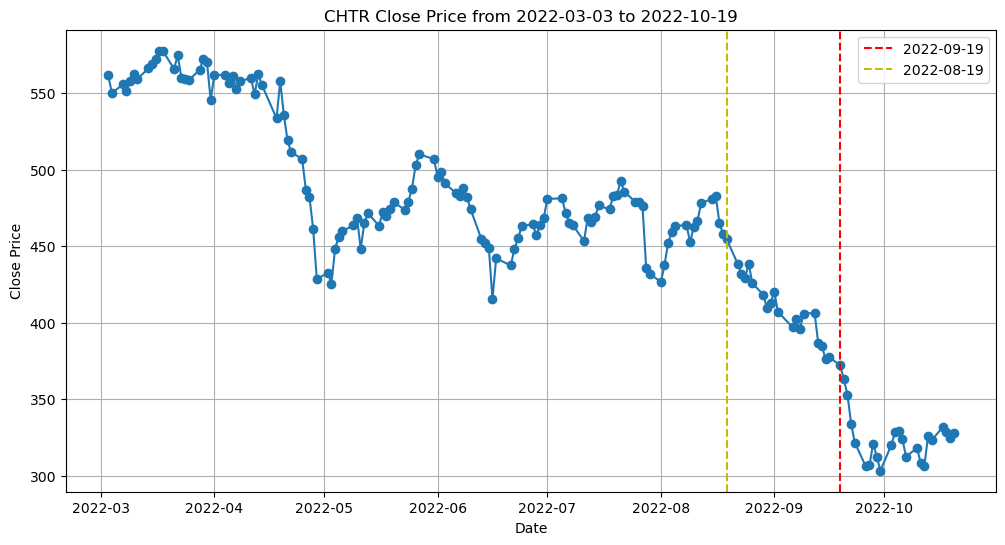

In [15]:
companyplot = 'CHTR'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-03-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2022-10-20').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-03-03 to 2022-10-19')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-09-19'), color='r', linestyle='--', label='2022-09-19')
plt.axvline(pd.to_datetime('2022-08-19'), color='y', linestyle='--', label='2022-08-19')
plt.legend()


plt.show()

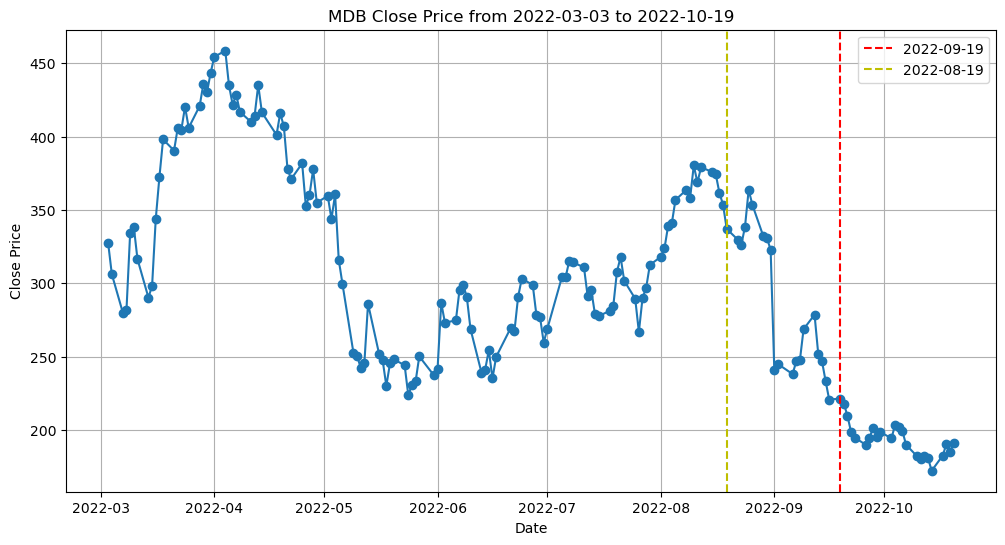

In [16]:
companyplot = 'MDB'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-03-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2022-10-20').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-03-03 to 2022-10-19')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-09-19'), color='r', linestyle='--', label='2022-09-19')
plt.axvline(pd.to_datetime('2022-08-19'), color='y', linestyle='--', label='2022-08-19')
plt.legend()


plt.show()

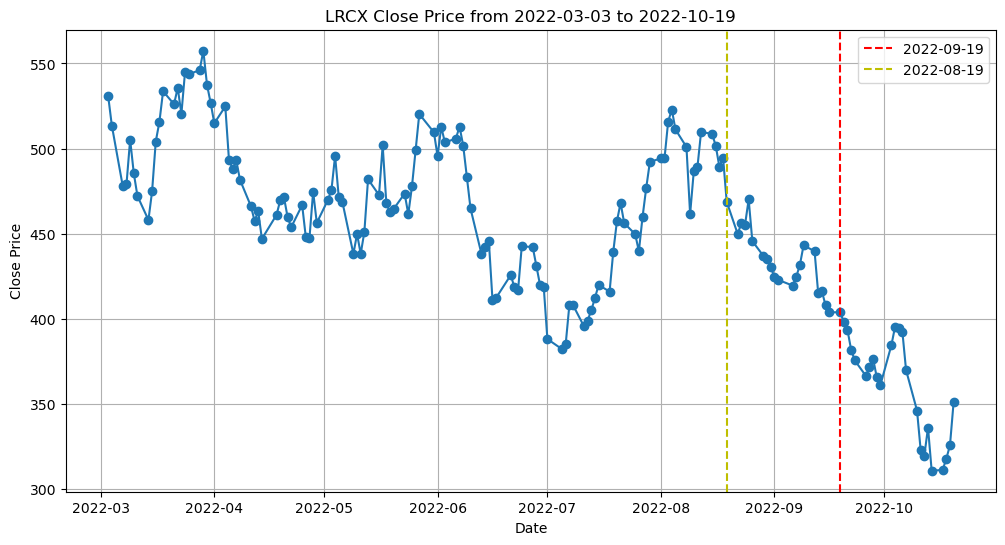

In [17]:
companyplot = 'LRCX'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-03-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2022-10-20').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-03-03 to 2022-10-19')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-09-19'), color='r', linestyle='--', label='2022-09-19')
plt.axvline(pd.to_datetime('2022-08-19'), color='y', linestyle='--', label='2022-08-19')
plt.legend()


plt.show()

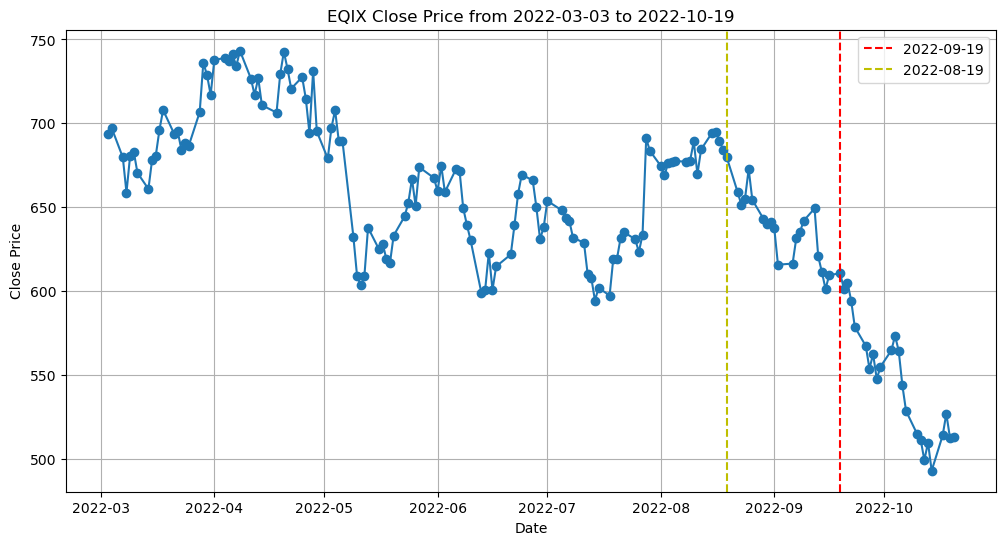

In [18]:
companyplot = 'EQIX'

filtered_data = stock_data[(stock_data['Date'] >= pd.Timestamp('2022-03-03').date()) & 
                           (stock_data['Date'] <=pd.Timestamp('2022-10-20').date()) & 
                           (stock_data['Company'] == companyplot)]


plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Date'], filtered_data['Close'], marker='o', linestyle='-')
plt.title(f'{companyplot} Close Price from 2022-03-03 to 2022-10-19')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)


plt.axvline(pd.to_datetime('2022-09-19'), color='r', linestyle='--', label='2022-09-19')
plt.axvline(pd.to_datetime('2022-08-19'), color='y', linestyle='--', label='2022-08-19')
plt.legend()


plt.show()